# Connecting dataset with osm

### Import the dataset

In [1]:
import geopandas as gpd
df_gpd = gpd.read_file('Fire_Incidents_cleaned.csv')

/home/student/.local/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Osm data preparation

In [3]:
import osmnx as ox

In [4]:
osm_tags = {
    'highway': [
        'motorway',
        'motorway_link',
        'trunk',
        'trunk_link',
        'primary',
        'primary_link',
        'secondary',
        'secondary_link',
        'tertiary',
        'tertiary_link',
        'residential',
        'living_street',
        'service',
        'unclassified'
    ]
}

### Downloading San Francisco map using osmnx library

In [5]:
gdf_osm = ox.geometries_from_place('San Francisco',tags=osm_tags)

In [6]:
gdf_osm.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Displaying San Francisco map

<AxesSubplot:>

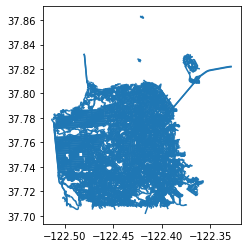

In [7]:
gdf_osm.plot()

In [8]:
gdf_osm.index

MultiIndex([('way',    5004035),
            ('way',    5071582),
            ('way',    7373728),
            ('way',    7373736),
            ('way',    7448875),
            ('way',    8914958),
            ('way',    8914960),
            ('way',    8914961),
            ('way',    8914964),
            ('way',    8914965),
            ...
            ('way', 1065802913),
            ('way', 1065802914),
            ('way', 1065847913),
            ('way', 1065848414),
            ('way', 1065853471),
            ('way', 1065853497),
            ('way', 1065853498),
            ('way', 1066161832),
            ('way', 1066975853),
            ('way', 1067214503)],
           names=['element_type', 'osmid'], length=20632)

In [9]:
gdf_lines = gdf_osm.loc['way', :]
gdf_lines['name']

osmid
5004035           Macondray Lane
5071582       James Lick Freeway
7373728               6th Street
7373736           Bluxome Street
7448875       Nelson Rising Lane
                     ...        
1065853497                   NaN
1065853498                   NaN
1066161832                   NaN
1066975853                   NaN
1067214503      Palo Alto Avenue
Name: name, Length: 20632, dtype: object

<AxesSubplot:>

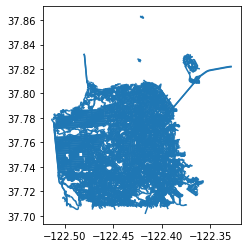

In [10]:
gdf_lines.plot()

### Changing geometry coordinates to meters

In [12]:
gdf_lines.to_crs('epsg:2178', inplace=True)

In [13]:
gdf_lines.head()

,highway,unsigned_ref,geometry,ref,railway,source,direction,stop,access,crossing,...,parking:lane,bridge:movable,bicycle:lanes:backward,delivery,pedestrian,opening_date,source:width,owner,oneway:vehicle,vehicle:lanes:forward
osmid,,,,,,,,,,,,,,,,,,,,,
5004035,residential,NaN,"LINESTRING (4234824.324 15125003.934, 4234895....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5071582,motorway,NaN,"LINESTRING (4228939.308 15133689.234, 4228949....",US 101,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7373728,residential,NaN,"LINESTRING (4232045.070 15127164.576, 4232044....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7373736,residential,NaN,"LINESTRING (4232045.070 15127164.576, 4232009....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7448875,residential,NaN,"LINESTRING (4230984.002 15127318.500, 4230994....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Fire Incidents dataset preparation

In [15]:
df_gpd.crs

#### Csv to geojson conversion

In [16]:
from geojson import Point
lonlat = []
for row in df_gpd["point"]:
    lon = float(row.split("(",1)[1].split(" ", 1)[0])
    lat = float(row.split("(",1)[1].split(" ", 1)[1][:-1])
    lonlat.append(Point((lon, lat)))

In [17]:
df_gpd["geometry"] = lonlat

#### Reprojection of the dataset into a planar (local) CRS

In [18]:
df_gpd.set_crs('epsg:4326', inplace=True)
gdf_lines.to_crs('epsg:2178', inplace=True)
df_gpd.to_crs('epsg:2178', inplace=True)

#### Creating a buffer around each point

In [19]:
#df_gpd['buffer_geom'] = df_gpd.geometry.buffer(10)
#df_gpd.head()

## Spatial join

In [20]:
df_joins = gpd.sjoin_nearest(
    gdf_lines[['name', 'geometry', 'highway']],
    df_gpd,
)
print(type(df_joins))
df_joins


<class 'geopandas.geodataframe.GeoDataFrame'>


,name,geometry,index_right,field_1,Unnamed: 0,Incident Number,Exposure Number,ID,Address,Incident Date,...,zipcode,Station Area,Estimated Property Loss,Estimated Contents Loss,Civilian Fatalities,Civilian Injuries,Number of Alarms,Supervisor District,neighborhood_district,point
osmid,,,,,,,,,,,,,,,,,,,,,
5004035,Macondray Lane,"LINESTRING (4234824.324 15125003.934, 4234895....",524665,524665,527408,20066314,0,200663140,MACONDRAY LANE,2020-06-07T00:00:00,...,94133.0,41.0,6767.806843863427,2264.2757016573787,0,0,1,6.141395416462207,Russian Hill,POINT (-122.417315 37.798941)
5071582,James Lick Freeway,"LINESTRING (4228939.308 15133689.234, 4228949....",304453,304453,304534,13012876,0,130128760,1 101SB C CHAVEZ ON,2013-02-07T00:00:00,...,94124.0,09,6767.806843863427,2264.2757016573787,0,0,1,10.0,Visitacion Valley,POINT (-122.398673 37.71694)
5071582,James Lick Freeway,"LINESTRING (4228939.308 15133689.234, 4228949....",151848,151848,151876,8018938,0,80189380,1 101sb C Chavez On,2008-03-01T00:00:00,...,94110.0,09,6767.806843863427,2264.2757016573787,0,0,1,10.0,Visitacion Valley,POINT (-122.398673 37.71694)
5071582,James Lick Freeway,"LINESTRING (4228939.308 15133689.234, 4228949....",227526,227526,227590,10080600,0,100806000,1 101sb C Chavez On,2010-09-12T00:00:00,...,94107.0,09,6767.806843863427,2264.2757016573787,0,0,1,10.0,Visitacion Valley,POINT (-122.398673 37.71694)
5071582,James Lick Freeway,"LINESTRING (4228939.308 15133689.234, 4228949....",407521,407521,409444,16116417,0,161164170,1 101NB BAYSHORE BL ON,2016-10-19T00:00:00,...,94124,42.0,6767.806843863427,2264.2757016573787,0,0,1,10.0,Visitacion Valley,POINT (-122.398673 37.71694)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065847913,NaN,"LINESTRING (4229559.310 15132523.583, 4229560....",174882,174882,174924,8107496,0,81074960,2660 Newhall St.,2008-12-17T00:00:00,...,94124.0,42,2000.0,50.0,0,0,1,10.0,Bayview Hunters Point,POINT (-122.39963625 37.72721219)
1065847913,NaN,"LINESTRING (4229559.310 15132523.583, 4229560....",23192,23192,23192,3070654,0,30706540,2660 Newhall St.,2003-09-04T00:00:00,...,94134,42,0.0,0.0,0,0,1,10.0,Bayview Hunters Point,POINT (-122.39963625 37.72721219)
1065847913,NaN,"LINESTRING (4229559.310 15132523.583, 4229560....",54709,54709,54709,4069400,0,40694000,2660 Newhall St.,2004-09-06T00:00:00,...,94124,42,0.0,0.0,0,0,1,10.0,Bayview Hunters Point,POINT (-122.39963625 37.72721219)


In [21]:
df_joins.to_csv('data_connected.csv')